# This code uses a .json file with file names and detected song intervals, then assembles either: 1) recording segments that contain song or 2) entire files that contain song

## Option 1: only generate spectrograms of detected song. 
### This code uses the time segments inside of the .json file to combine songs into 1 minute .wav files containing song, then saves those .wav files and generates .pngs of their spectrograms.

In [1]:
import os
import numpy as np
import json
from scipy.io import wavfile
from pathlib import Path

# === CONFIG ===
folder_path = '/Users/mirandahulsey-vincent/Documents/allPythonCode/BYOD_class/data_inputs/USA5510_unsegmented_songs/55'  # Update this path
json_path = '/Users/mirandahulsey-vincent/Documents/allPythonCode/BYOD_class/data_inputs/USA5510_unsegmented_songs/55_ampltidue_only_detected_song_intervals.json'  # Update this path
output_folder = os.path.join(folder_path, 'detected_song_minutes')
if not os.path.exists(output_folder):
    os.makedirs(output_folder)

# === Load JSON Detected Intervals ===
with open(json_path, 'r') as f:
    detected_intervals = json.load(f)

# === Step 1: Extract detected segments ===
detected_segments = []
sample_rate_reference = None

for file_name, intervals in detected_intervals.items():
    wav_path = os.path.join(folder_path, file_name)
    if not os.path.exists(wav_path):
        print(f"Missing file: {file_name}")
        continue

    try:
        samplerate, data = wavfile.read(wav_path)
        if sample_rate_reference is None:
            sample_rate_reference = samplerate
        elif samplerate != sample_rate_reference:
            raise ValueError(f"Sample rate mismatch in {file_name}")

        if data.ndim > 1:
            data = data.mean(axis=1)

        for start_time, end_time in intervals:
            start_sample = int(start_time * samplerate)
            end_sample = int(end_time * samplerate)
            detected_segments.append(data[start_sample:end_sample])
    except Exception as e:
        print(f"Error reading {file_name}: {e}")
        continue

# === Step 2: Concatenate into 1-minute chunks ===
target_samples = 60 * sample_rate_reference
concatenated = np.concatenate(detected_segments)

minute_segments = []
for i in range(0, len(concatenated), target_samples):
    chunk = concatenated[i:i + target_samples]
    if len(chunk) == target_samples:
        minute_segments.append(chunk)

# === Step 3: Save 1-minute .wav files ===
for i, segment in enumerate(minute_segments):
    output_path = os.path.join(output_folder, f'detected_song_minute_{i+1}.wav')
    wavfile.write(output_path, sample_rate_reference, segment.astype(np.int16))
    print(f"Saved: {output_path}")


Saved: /Users/mirandahulsey-vincent/Documents/allPythonCode/BYOD_class/data_inputs/USA5510_unsegmented_songs/55/detected_song_minutes/detected_song_minute_1.wav
Saved: /Users/mirandahulsey-vincent/Documents/allPythonCode/BYOD_class/data_inputs/USA5510_unsegmented_songs/55/detected_song_minutes/detected_song_minute_2.wav
Saved: /Users/mirandahulsey-vincent/Documents/allPythonCode/BYOD_class/data_inputs/USA5510_unsegmented_songs/55/detected_song_minutes/detected_song_minute_3.wav
Saved: /Users/mirandahulsey-vincent/Documents/allPythonCode/BYOD_class/data_inputs/USA5510_unsegmented_songs/55/detected_song_minutes/detected_song_minute_4.wav
Saved: /Users/mirandahulsey-vincent/Documents/allPythonCode/BYOD_class/data_inputs/USA5510_unsegmented_songs/55/detected_song_minutes/detected_song_minute_5.wav
Saved: /Users/mirandahulsey-vincent/Documents/allPythonCode/BYOD_class/data_inputs/USA5510_unsegmented_songs/55/detected_song_minutes/detected_song_minute_6.wav
Saved: /Users/mirandahulsey-vincen

In [2]:
import numpy as np
import os
from pathlib import Path
from scipy.io import wavfile
from scipy.signal import spectrogram, windows, ellip, filtfilt
import matplotlib.pyplot as plt
import tkinter as tk
import json

def get_screen_resolution():
    root = tk.Tk()
    root.withdraw()
    screen_width = root.winfo_screenwidth()
    screen_height = root.winfo_screenheight()
    root.destroy()
    return screen_width / 100, screen_height / 100  # inches

width_inches, height_inches = get_screen_resolution()

# === Load JSON file once
with open(json_path, 'r') as f:
    file_lists = json.load(f)

def process_wav_file(file_path, spectrogram_folder, segment_duration=10, low_cut=500, high_cut=8000):
    try:
        base_name = Path(file_path).stem
        samplerate, data = wavfile.read(file_path)
        if data.ndim > 1:
            data = data.mean(axis=1)

        nyquist = samplerate / 2
        wp = [low_cut / nyquist, high_cut / nyquist]
        b, a = ellip(5, 0.2, 40, wp, btype='band')
        data = filtfilt(b, a, data)

        duration_seconds = data.shape[0] / samplerate
        segment_length_samples = int(segment_duration * samplerate)
        num_segments = min(6, int(np.ceil(duration_seconds / segment_duration)))

        spectrogram_fig_path = os.path.join(spectrogram_folder, f"{base_name}_spectrogram.png")

        fig, axs = plt.subplots(num_segments, 1, figsize=(width_inches, height_inches), sharex=True, gridspec_kw={'hspace': 0.0})
        if num_segments == 1:
            axs = [axs]

        red_lines_sec = []
        if f"{base_name}.wav" in file_lists:
            red_lines_sec = [entry["start_sample"] / samplerate for entry in file_lists[f"{base_name}.wav"]]

        for i in range(num_segments):
            start_sample = i * segment_length_samples
            end_sample = start_sample + segment_length_samples
            segment_data = np.zeros(segment_length_samples, dtype=data.dtype)
            if start_sample < data.shape[0]:
                segment_data[:max(0, min(segment_length_samples, data.shape[0] - start_sample))] = data[start_sample:end_sample]

            f, t, Sxx = spectrogram(
                segment_data,
                fs=samplerate,
                window=windows.gaussian(2048, std=2048/8),
                nperseg=2048,
                noverlap=(2048 - 119)
            )

            Sxx_log = 10 * np.log10(Sxx + np.finfo(float).eps)
            Sxx_log_clipped = np.clip(Sxx_log, a_min=3, a_max=None)
            Sxx_log_normalized = (Sxx_log_clipped - np.min(Sxx_log_clipped)) / (np.max(Sxx_log_clipped) - np.min(Sxx_log_clipped))
            Sxx_log_normalized = np.power(Sxx_log_normalized, 0.7)

            axs[i].imshow(Sxx_log_normalized, aspect='auto', origin='lower',
                          extent=[0, segment_duration, f.min(), f.max()], cmap='binary')

            for x in red_lines_sec:
                if start_sample / samplerate <= x < end_sample / samplerate:
                    axs[i].axvline(x - (start_sample / samplerate), color='red', linestyle='-', linewidth=1)

            axs[i].set_ylabel('Freq [Hz]')
            if i == num_segments - 1:
                axs[i].set_xlabel('Time [sec]')
                axs[i].set_xticks(np.linspace(0, segment_duration, 5))

        fig.suptitle(f'{base_name} – Spectrogram (Filtered {low_cut}-{high_cut} Hz)', fontsize=14)
        fig.tight_layout()
        fig.savefig(spectrogram_fig_path, dpi=300)
        plt.close(fig)
        print(f"✅ Saved: {spectrogram_fig_path}\n")

    except Exception as e:
        print(f"❌ Error processing {file_path}: {e}")

def batch_process_folder(folder_path, segment_duration=10):
    output_folder = os.path.join(folder_path)
    spectrogram_folder = os.path.join(output_folder, "spectrograms")
    os.makedirs(spectrogram_folder, exist_ok=True)

    wav_files = [f for f in Path(folder_path).glob("*.wav")]
    if not wav_files:
        print("No .wav files found in the selected folder.")
        return

    print(f"\n📂 Processing {len(wav_files)} files in: {folder_path}\n")
    for wav_file in wav_files:
        process_wav_file(wav_file, spectrogram_folder, segment_duration=segment_duration)

# === USER INPUT ===
#folder_path = '/Users/mirandahulsey-vincent/Documents/allPythonCode/BYOD_class/data_inputs/USA5510_unsegmented_songs/55/detected_song_minutes'
folder_path = folder_path + '/detected_song_minutes'
batch_process_folder(
    folder_path,
    segment_duration=10  # Each panel = 10s; total of 6 panels = 60s
)



📂 Processing 10 files in: /Users/mirandahulsey-vincent/Documents/allPythonCode/BYOD_class/data_inputs/USA5510_unsegmented_songs/55/detected_song_minutes

✅ Saved: /Users/mirandahulsey-vincent/Documents/allPythonCode/BYOD_class/data_inputs/USA5510_unsegmented_songs/55/detected_song_minutes/spectrograms/detected_song_minute_2_spectrogram.png

✅ Saved: /Users/mirandahulsey-vincent/Documents/allPythonCode/BYOD_class/data_inputs/USA5510_unsegmented_songs/55/detected_song_minutes/spectrograms/detected_song_minute_3_spectrogram.png

✅ Saved: /Users/mirandahulsey-vincent/Documents/allPythonCode/BYOD_class/data_inputs/USA5510_unsegmented_songs/55/detected_song_minutes/spectrograms/detected_song_minute_1_spectrogram.png

✅ Saved: /Users/mirandahulsey-vincent/Documents/allPythonCode/BYOD_class/data_inputs/USA5510_unsegmented_songs/55/detected_song_minutes/spectrograms/detected_song_minute_4_spectrogram.png

✅ Saved: /Users/mirandahulsey-vincent/Documents/allPythonCode/BYOD_class/data_inputs/USA5

# Option 2: This portion combines all .wav files containing songs into 1-minute recordings, then  generates spectrograms of them.

In [3]:
import os
import numpy as np
import json
from scipy.io import wavfile
from pathlib import Path

# === CONFIG ===
folder_path = '/Users/mirandahulsey-vincent/Documents/allPythonCode/BYOD_class/data_inputs/USA5510_unsegmented_songs/55'
#json_path = '/Users/mirandahulsey-vincent/Documents/allPythonCode/BYOD_class/data_inputs/USA5510_unsegmented_songs/55_detected_song_intervals.json'

# Output folder
output_folder = folder_path + '_detected_song_files_full_recordings'
if not os.path.exists(output_folder):
    os.makedirs(output_folder)

# === Load Detected Intervals ===
with open(json_path, 'r') as f:
    detected_intervals = json.load(f)

# === Step 1: Sort the files for consistent order ===
file_names = sorted(detected_intervals.keys())

# === Step 2: Load full files with detected song ===
audio_queue = []
sample_rate_reference = None

for file_name in file_names:
    wav_path = os.path.join(folder_path, file_name)
    if not os.path.exists(wav_path):
        print(f"Missing file: {file_name}")
        continue

    try:
        samplerate, data = wavfile.read(wav_path)

        if sample_rate_reference is None:
            sample_rate_reference = samplerate
        elif samplerate != sample_rate_reference:
            raise ValueError(f"Sample rate mismatch in {file_name}")

        if data.ndim > 1:
            data = data.mean(axis=1)  # Convert to mono

        audio_queue.append(data)

    except Exception as e:
        print(f"Error reading {file_name}: {e}")
        continue

# === Step 3: Chunk into 1-minute segments ===
minute_samples = 60 * sample_rate_reference
leftover = np.array([], dtype=np.float32)
chunk_count = 0

for segment in audio_queue:
    # Combine leftover from previous file
    combined = np.concatenate([leftover, segment])

    # Chop into full 1-minute chunks
    while len(combined) >= minute_samples:
        chunk = combined[:minute_samples]
        output_filename = f'detected_song_minute_{chunk_count + 1}.wav'
        output_path = os.path.join(output_folder, output_filename)
        wavfile.write(output_path, sample_rate_reference, chunk.astype(np.int16))
        print(f"Saved: {output_path}")

        chunk_count += 1
        combined = combined[minute_samples:]  # keep the remainder

    leftover = combined  # update leftover for next file

# === Step 4: Save final leftover if non-empty
if len(leftover) > 0:
    padded = np.pad(leftover, (0, minute_samples - len(leftover)), mode='constant')
    chunk_count += 1
    output_filename = f'detected_song_minute_{chunk_count}.wav'
    output_path = os.path.join(output_folder, output_filename)
    wavfile.write(output_path, sample_rate_reference, padded.astype(np.int16))
    print(f"Saved final partial chunk: {output_path}")

Saved: /Users/mirandahulsey-vincent/Documents/allPythonCode/BYOD_class/data_inputs/USA5510_unsegmented_songs/55_detected_song_files_full_recordings/detected_song_minute_1.wav
Saved: /Users/mirandahulsey-vincent/Documents/allPythonCode/BYOD_class/data_inputs/USA5510_unsegmented_songs/55_detected_song_files_full_recordings/detected_song_minute_2.wav
Saved: /Users/mirandahulsey-vincent/Documents/allPythonCode/BYOD_class/data_inputs/USA5510_unsegmented_songs/55_detected_song_files_full_recordings/detected_song_minute_3.wav
Saved: /Users/mirandahulsey-vincent/Documents/allPythonCode/BYOD_class/data_inputs/USA5510_unsegmented_songs/55_detected_song_files_full_recordings/detected_song_minute_4.wav
Saved: /Users/mirandahulsey-vincent/Documents/allPythonCode/BYOD_class/data_inputs/USA5510_unsegmented_songs/55_detected_song_files_full_recordings/detected_song_minute_5.wav
Saved: /Users/mirandahulsey-vincent/Documents/allPythonCode/BYOD_class/data_inputs/USA5510_unsegmented_songs/55_detected_song

In [4]:
import os
import numpy as np
import json
from scipy.io import wavfile
from pathlib import Path

# === CONFIG ===
#folder_path = '/Users/mirandahulsey-vincent/Documents/allPythonCode/BYOD_class/data_inputs/USA5510_unsegmented_songs/55'
#json_path = '/Users/mirandahulsey-vincent/Documents/allPythonCode/BYOD_class/data_inputs/USA5510_unsegmented_songs/55_detected_song_intervals.json'

# Output folder and metadata path
output_folder = folder_path + '_detected_song_files_full_recordings'
if not os.path.exists(output_folder):
    os.makedirs(output_folder)

metadata_output_path = os.path.join(output_folder, 'segment_metadata.json')
segment_metadata = {}

# === Load Detected Intervals ===
with open(json_path, 'r') as f:
    detected_intervals = json.load(f)

# === Sort files to ensure consistent processing order ===
file_names = sorted(detected_intervals.keys())

# === Step 1: Load full audio files with detected song ===
audio_queue = []
sample_rate_reference = None

for file_name in file_names:
    wav_path = os.path.join(folder_path, file_name)
    if not os.path.exists(wav_path):
        print(f"Missing file: {file_name}")
        continue

    try:
        samplerate, data = wavfile.read(wav_path)

        if sample_rate_reference is None:
            sample_rate_reference = samplerate
        elif samplerate != sample_rate_reference:
            raise ValueError(f"Sample rate mismatch in {file_name}")

        if data.ndim > 1:
            data = data.mean(axis=1)  # Convert stereo to mono

        audio_queue.append((file_name, data))

    except Exception as e:
        print(f"Error reading {file_name}: {e}")
        continue

# === Step 2: Assemble 1-minute segments with provenance tracking ===
minute_samples = 60 * sample_rate_reference
leftover = np.array([], dtype=np.float32)
leftover_provenance = []

chunk_count = 0
current_chunk = []
current_provenance = []

def finalize_chunk(chunk_data, provenance_list, chunk_index):
    output_filename = f'detected_song_minute_{chunk_index + 1}.wav'
    output_path = os.path.join(output_folder, output_filename)
    wavfile.write(output_path, sample_rate_reference, chunk_data.astype(np.int16))
    segment_metadata[output_filename] = provenance_list
    print(f"Saved: {output_path}")

for file_name, data in audio_queue:
    total_samples = len(data)

    # Add leftover from previous file
    combined = np.concatenate([leftover, data])
    combined_provenance = leftover_provenance.copy()

    if leftover.size > 0:
        combined_provenance.append({
            'source_file': leftover_provenance[-1]['source_file'],
            'segment_in_chunk': [0, len(leftover) / sample_rate_reference]
        })

    combined_provenance.append({
        'source_file': file_name,
        'segment_in_chunk': [
            len(leftover) / sample_rate_reference,
            (len(leftover) + total_samples) / sample_rate_reference
        ]
    })

    # Slice into full 1-minute chunks
    cursor = 0
    while len(combined) - cursor >= minute_samples:
        chunk = combined[cursor:cursor + minute_samples]

        # Calculate provenance within this chunk
        chunk_provenance = []
        chunk_start = cursor
        chunk_end = cursor + minute_samples
        for entry in combined_provenance:
            source_file = entry['source_file']
            seg_start_sec, seg_end_sec = entry['segment_in_chunk']
            seg_start = int(seg_start_sec * sample_rate_reference)
            seg_end = int(seg_end_sec * sample_rate_reference)

            # Determine overlap with current chunk
            overlap_start = max(chunk_start, seg_start)
            overlap_end = min(chunk_end, seg_end)

            if overlap_start < overlap_end:
                chunk_start_in_sec = (overlap_start - chunk_start) / sample_rate_reference
                chunk_end_in_sec = (overlap_end - chunk_start) / sample_rate_reference
                chunk_provenance.append({
                    'source_file': source_file,
                    'time_range_in_chunk_seconds': [round(chunk_start_in_sec, 3), round(chunk_end_in_sec, 3)]
                })

        finalize_chunk(chunk, chunk_provenance, chunk_count)
        chunk_count += 1
        cursor += minute_samples

    # Save the remainder for the next chunk
    leftover = combined[cursor:]
    leftover_provenance = [{
        'source_file': file_name,
        'segment_in_chunk': [
            (cursor - len(combined) + total_samples) / sample_rate_reference,
            total_samples / sample_rate_reference
        ]
    }]

# === Step 3: Final leftover segment (pad if needed) ===
if len(leftover) > 0:
    padded = np.pad(leftover, (0, minute_samples - len(leftover)), mode='constant')

    # Adjust final provenance times
    final_provenance = []
    total_sec = len(leftover) / sample_rate_reference
    for entry in leftover_provenance:
        seg_start = entry['segment_in_chunk'][0]
        seg_end = entry['segment_in_chunk'][1]
        seg_end = min(seg_end, seg_start + total_sec)
        final_provenance.append({
            'source_file': entry['source_file'],
            'time_range_in_chunk_seconds': [
                round(seg_start, 3),
                round(seg_end, 3)
            ]
        })

    finalize_chunk(padded, final_provenance, chunk_count)

# === Step 4: Save metadata JSON ===
with open(metadata_output_path, 'w') as f:
    json.dump(segment_metadata, f, indent=2)

print(f"Metadata saved to: {metadata_output_path}")

Saved: /Users/mirandahulsey-vincent/Documents/allPythonCode/BYOD_class/data_inputs/USA5510_unsegmented_songs/55_detected_song_files_full_recordings/detected_song_minute_1.wav
Saved: /Users/mirandahulsey-vincent/Documents/allPythonCode/BYOD_class/data_inputs/USA5510_unsegmented_songs/55_detected_song_files_full_recordings/detected_song_minute_2.wav
Saved: /Users/mirandahulsey-vincent/Documents/allPythonCode/BYOD_class/data_inputs/USA5510_unsegmented_songs/55_detected_song_files_full_recordings/detected_song_minute_3.wav
Saved: /Users/mirandahulsey-vincent/Documents/allPythonCode/BYOD_class/data_inputs/USA5510_unsegmented_songs/55_detected_song_files_full_recordings/detected_song_minute_4.wav
Saved: /Users/mirandahulsey-vincent/Documents/allPythonCode/BYOD_class/data_inputs/USA5510_unsegmented_songs/55_detected_song_files_full_recordings/detected_song_minute_5.wav
Saved: /Users/mirandahulsey-vincent/Documents/allPythonCode/BYOD_class/data_inputs/USA5510_unsegmented_songs/55_detected_song

In [5]:
import os
import numpy as np
import json
from scipy.io import wavfile
from pathlib import Path

# === CONFIG ===
#folder_path = '/Users/mirandahulsey-vincent/Documents/allPythonCode/BYOD_class/data_inputs/USA5510_unsegmented_songs/55'
#json_path = '/Users/mirandahulsey-vincent/Documents/allPythonCode/BYOD_class/data_inputs/USA5510_unsegmented_songs/55_detected_song_intervals.json'

output_folder = folder_path + '_detected_song_files_full_recordings'
if not os.path.exists(output_folder):
    os.makedirs(output_folder)

metadata_output_path = os.path.join(output_folder, 'segment_metadata.json')

# === Load Detected Intervals ===
with open(json_path, 'r') as f:
    detected_intervals = json.load(f)

# === Sort files for reproducibility ===
file_names = sorted(detected_intervals.keys())

audio_queue = []
sample_rate_reference = None

for file_name in file_names:
    wav_path = os.path.join(folder_path, file_name)
    if not os.path.exists(wav_path):
        print(f"Missing file: {file_name}")
        continue

    try:
        samplerate, data = wavfile.read(wav_path)

        if sample_rate_reference is None:
            sample_rate_reference = samplerate
        elif samplerate != sample_rate_reference:
            raise ValueError(f"Sample rate mismatch in {file_name}")

        if data.ndim > 1:
            data = data.mean(axis=1)  # mono

        audio_queue.append((file_name, data))

    except Exception as e:
        print(f"Error reading {file_name}: {e}")
        continue

# === Chunks ===
minute_samples = 60 * sample_rate_reference
leftover = np.array([], dtype=np.float32)
leftover_provenance = []
segment_metadata = {}
chunk_count = 0

def get_song_segments_within_range(file_name, range_start, range_end):
    """Get adjusted song intervals from a file that fall within a sample range."""
    song_segments = []
    for start_time, end_time in detected_intervals.get(file_name, []):
        start_sample = int(start_time * sample_rate_reference)
        end_sample = int(end_time * sample_rate_reference)
        overlap_start = max(start_sample, range_start)
        overlap_end = min(end_sample, range_end)
        if overlap_start < overlap_end:
            relative_start = (overlap_start - range_start) / sample_rate_reference
            relative_end = (overlap_end - range_start) / sample_rate_reference
            song_segments.append([round(relative_start, 3), round(relative_end, 3)])
    return song_segments

def finalize_chunk(chunk_data, provenance_list, song_segments, chunk_index):
    output_filename = f'detected_song_minute_{chunk_index + 1}.wav'
    output_path = os.path.join(output_folder, output_filename)
    wavfile.write(output_path, sample_rate_reference, chunk_data.astype(np.int16))
    segment_metadata[output_filename] = {
        "source_files": provenance_list,
        "song_segments_in_chunk": song_segments
    }
    print(f"Saved: {output_path}")

for file_name, data in audio_queue:
    total_samples = len(data)

    # Combine with leftover
    combined = np.concatenate([leftover, data])
    combined_provenance = []
    combined_song_segments = []

    combined_ranges = []
    current_offset = 0

    if len(leftover) > 0:
        combined_ranges.append({
            "source_file": leftover_provenance[-1]["source_file"],
            "range_start": 0,
            "range_end": len(leftover)
        })
        current_offset = len(leftover)

    combined_ranges.append({
        "source_file": file_name,
        "range_start": current_offset,
        "range_end": current_offset + len(data)
    })

    # Chunk slicing loop
    cursor = 0
    while cursor + minute_samples <= len(combined):
        chunk = combined[cursor:cursor + minute_samples]
        chunk_provenance = []
        chunk_song_segments = []

        chunk_start = cursor
        chunk_end = cursor + minute_samples

        for entry in combined_ranges:
            source_file = entry["source_file"]
            source_start = entry["range_start"]
            source_end = entry["range_end"]

            # Determine overlap with chunk
            overlap_start = max(chunk_start, source_start)
            overlap_end = min(chunk_end, source_end)

            if overlap_start < overlap_end:
                # Provenance info
                prov_start_sec = (overlap_start - chunk_start) / sample_rate_reference
                prov_end_sec = (overlap_end - chunk_start) / sample_rate_reference
                chunk_provenance.append({
                    "source_file": source_file,
                    "time_range_in_chunk_seconds": [round(prov_start_sec, 3), round(prov_end_sec, 3)]
                })

                # Song segment info
                rel_range_start = overlap_start - source_start
                rel_range_end = overlap_end - source_start
                song_segs = get_song_segments_within_range(source_file, rel_range_start, rel_range_end)
                for s in song_segs:
                    adjusted = [
                        round(s[0] + prov_start_sec, 3),
                        round(s[1] + prov_start_sec, 3)
                    ]
                    chunk_song_segments.append(adjusted)

        finalize_chunk(chunk, chunk_provenance, chunk_song_segments, chunk_count)
        chunk_count += 1
        cursor += minute_samples

    # Keep remainder for next round
    leftover = combined[cursor:]
    leftover_provenance = [{"source_file": file_name}]

# Final chunk
if len(leftover) > 0:
    padded = np.pad(leftover, (0, minute_samples - len(leftover)), mode='constant')
    final_song_segments = []
    if leftover_provenance:
        source_file = leftover_provenance[0]["source_file"]
        song_segs = get_song_segments_within_range(source_file, 0, len(leftover))
        final_song_segments = song_segs

    finalize_chunk(padded, [{"source_file": leftover_provenance[0]["source_file"], "time_range_in_chunk_seconds": [0.0, len(leftover) / sample_rate_reference]}], final_song_segments, chunk_count)

# Save metadata
with open(metadata_output_path, 'w') as f:
    json.dump(segment_metadata, f, indent=2)

print(f"Metadata saved to: {metadata_output_path}")

Saved: /Users/mirandahulsey-vincent/Documents/allPythonCode/BYOD_class/data_inputs/USA5510_unsegmented_songs/55_detected_song_files_full_recordings/detected_song_minute_1.wav
Saved: /Users/mirandahulsey-vincent/Documents/allPythonCode/BYOD_class/data_inputs/USA5510_unsegmented_songs/55_detected_song_files_full_recordings/detected_song_minute_2.wav
Saved: /Users/mirandahulsey-vincent/Documents/allPythonCode/BYOD_class/data_inputs/USA5510_unsegmented_songs/55_detected_song_files_full_recordings/detected_song_minute_3.wav
Saved: /Users/mirandahulsey-vincent/Documents/allPythonCode/BYOD_class/data_inputs/USA5510_unsegmented_songs/55_detected_song_files_full_recordings/detected_song_minute_4.wav
Saved: /Users/mirandahulsey-vincent/Documents/allPythonCode/BYOD_class/data_inputs/USA5510_unsegmented_songs/55_detected_song_files_full_recordings/detected_song_minute_5.wav
Saved: /Users/mirandahulsey-vincent/Documents/allPythonCode/BYOD_class/data_inputs/USA5510_unsegmented_songs/55_detected_song


📂 Processing 168 files in: /Users/mirandahulsey-vincent/Documents/allPythonCode/BYOD_class/data_inputs/USA5510_unsegmented_songs/55_detected_song_files_full_recordings

✅ Saved: /Users/mirandahulsey-vincent/Documents/allPythonCode/BYOD_class/data_inputs/USA5510_unsegmented_songs/55_detected_song_files_full_recordings/spectrograms/detected_song_minute_147_spectrogram.png

✅ Saved: /Users/mirandahulsey-vincent/Documents/allPythonCode/BYOD_class/data_inputs/USA5510_unsegmented_songs/55_detected_song_files_full_recordings/spectrograms/detected_song_minute_153_spectrogram.png

✅ Saved: /Users/mirandahulsey-vincent/Documents/allPythonCode/BYOD_class/data_inputs/USA5510_unsegmented_songs/55_detected_song_files_full_recordings/spectrograms/detected_song_minute_2_spectrogram.png

✅ Saved: /Users/mirandahulsey-vincent/Documents/allPythonCode/BYOD_class/data_inputs/USA5510_unsegmented_songs/55_detected_song_files_full_recordings/spectrograms/detected_song_minute_91_spectrogram.png

✅ Saved: /Use

KeyboardInterrupt: 

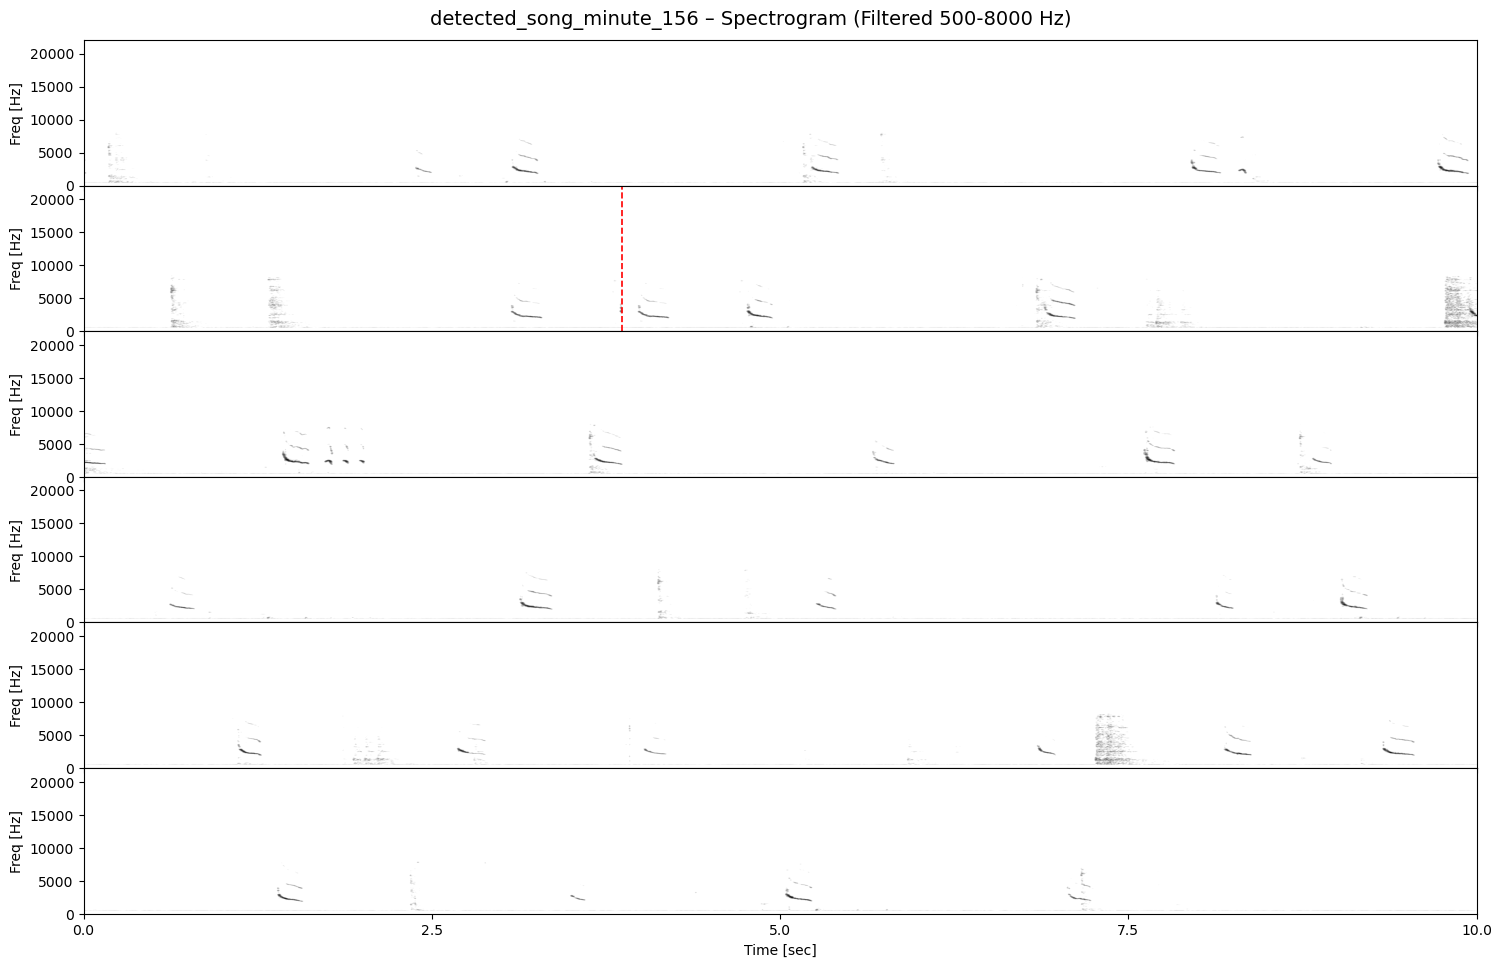

In [12]:
def process_wav_file(file_path, spectrogram_folder, segment_duration=10, low_cut=500, high_cut=8000):
    try:
        base_name = Path(file_path).stem
        samplerate, data = wavfile.read(file_path)
        if data.ndim > 1:
            data = data.mean(axis=1)

        # === Apply Bandpass Filter ===
        nyquist = samplerate / 2
        wp = [low_cut / nyquist, high_cut / nyquist]
        b, a = ellip(5, 0.2, 40, wp, btype='band')
        data = filtfilt(b, a, data)

        duration_seconds = data.shape[0] / samplerate
        segment_length_samples = int(segment_duration * samplerate)
        num_segments = min(6, int(np.ceil(duration_seconds / segment_duration)))

        spectrogram_fig_path = os.path.join(spectrogram_folder, f"{base_name}_spectrogram.png")

        fig, axs = plt.subplots(num_segments, 1, figsize=(width_inches, height_inches), sharex=True, gridspec_kw={'hspace': 0.0})
        if num_segments == 1:
            axs = [axs]

        metadata_key = f"{base_name}.wav"
        song_intervals = []
        boundary_lines = []

        if metadata_key in segment_metadata:
            entry = segment_metadata[metadata_key]
            song_intervals = entry.get("song_segments_in_chunk", [])
            for src in entry.get("source_files", []):
                if "time_range_in_chunk_seconds" in src:
                    end = src["time_range_in_chunk_seconds"][1]
                    boundary_lines.append(end)

        for i in range(num_segments):
            start_sample = i * segment_length_samples
            end_sample = start_sample + segment_length_samples
            segment_data = np.zeros(segment_length_samples, dtype=data.dtype)
            if start_sample < data.shape[0]:
                segment_data[:max(0, min(segment_length_samples, data.shape[0] - start_sample))] = data[start_sample:end_sample]

            f, t, Sxx = spectrogram(
                segment_data,
                fs=samplerate,
                window=windows.gaussian(2048, std=2048/8),
                nperseg=2048,
                noverlap=(2048 - 119)
            )

            Sxx_log = 10 * np.log10(Sxx + np.finfo(float).eps)
            Sxx_log_clipped = np.clip(Sxx_log, a_min=3, a_max=None)
            Sxx_log_normalized = (Sxx_log_clipped - np.min(Sxx_log_clipped)) / (np.max(Sxx_log_clipped) - np.min(Sxx_log_clipped))
            Sxx_log_normalized = np.power(Sxx_log_normalized, 0.7)

            axs[i].imshow(Sxx_log_normalized, aspect='auto', origin='lower',
                          extent=[0, segment_duration, f.min(), f.max()], cmap='binary')

            # === Yellow highlight for song intervals ===
            panel_start = i * segment_duration
            panel_end = panel_start + segment_duration
            for interval_start, interval_end in song_intervals:
                if interval_start < panel_end and interval_end > panel_start:
                    x0 = max(0, interval_start - panel_start)
                    x1 = min(segment_duration, interval_end - panel_start)
                    axs[i].axvspan(x0, x1, color='yellow', alpha=0.4)

            # === Red dashed lines for source boundaries ===
            for boundary_time in boundary_lines:
                if panel_start < boundary_time < panel_end:
                    axs[i].axvline(boundary_time - panel_start, color='red', linestyle='--', linewidth=1.2)

            axs[i].set_ylabel('Freq [Hz]')
            if i == num_segments - 1:
                axs[i].set_xlabel('Time [sec]')
                axs[i].set_xticks(np.linspace(0, segment_duration, 5))

        fig.suptitle(f'{base_name} – Spectrogram (Filtered {low_cut}-{high_cut} Hz)', fontsize=14)
        fig.tight_layout()
        fig.savefig(spectrogram_fig_path, dpi=300)
        plt.close(fig)
        print(f"✅ Saved: {spectrogram_fig_path}\n")

    except Exception as e:
        print(f"❌ Error processing {file_path}: {e}")


def batch_process_folder(folder_path, segment_duration=10):
    output_folder = os.path.join(folder_path)
    spectrogram_folder = os.path.join(output_folder, "spectrograms")
    os.makedirs(spectrogram_folder, exist_ok=True)

    wav_files = [f for f in Path(folder_path).glob("*.wav")]
    if not wav_files:
        print("No .wav files found in the selected folder.")
        return

    print(f"\n📂 Processing {len(wav_files)} files in: {folder_path}\n")
    for wav_file in wav_files:
        process_wav_file(wav_file, spectrogram_folder, segment_duration=segment_duration)

# === USER INPUT ===
folder_path = '/Users/mirandahulsey-vincent/Documents/allPythonCode/BYOD_class/data_inputs/USA5510_unsegmented_songs/55_detected_song_files_full_recordings'
batch_process_folder(
    folder_path,
    segment_duration=10  # Each panel = 10s; total of 6 panels = 60s
)

In [7]:
# import os
# import numpy as np
# import json
# from scipy.io import wavfile
# from pathlib import Path

# # === CONFIG ===
# folder_path = '/Users/mirandahulsey-vincent/Documents/allPythonCode/BYOD_class/data_inputs/USA5510_unsegmented_songs/55'
# json_path = '/Users/mirandahulsey-vincent/Documents/allPythonCode/BYOD_class/data_inputs/USA5510_unsegmented_songs/55_amplitude_only_detected_song_intervals.json'

# # Output folder
# output_folder = folder_path + '_detected_song_files_full_recordings'
# if not os.path.exists(output_folder):
#     os.makedirs(output_folder)

# # === Load Detected Intervals ===
# with open(json_path, 'r') as f:
#     detected_intervals = json.load(f)

# # === Step 1: Sort the files for consistent order ===
# # Iterate through the list directly instead of using keys()
# file_names = [entry['file_name'] for entry in detected_intervals]
# file_names.sort()

# # === Step 2: Load full files with detected song ===
# audio_queue = []
# sample_rate_reference = None

# for file_name in file_names:
#     # Find the entry for the current file_name
#     entry = next((item for item in detected_intervals if item['file_name'] == file_name), None)
#     if entry is None:
#         print(f"File not found in the list: {file_name}")
#         continue

#     wav_path = entry['file_path']
#     if not os.path.exists(wav_path):
#         print(f"Missing file: {file_name}")
#         continue

#     try:
#         samplerate, data = wavfile.read(wav_path)

#         if sample_rate_reference is None:
#             sample_rate_reference = samplerate
#         elif samplerate != sample_rate_reference:
#             raise ValueError(f"Sample rate mismatch in {file_name}")

#         if data.ndim > 1:
#             data = data.mean(axis=1)  # Convert to mono

#         audio_queue.append(data)

#     except Exception as e:
#         print(f"Error reading {file_name}: {e}")
#         continue

# # === Step 3: Chunk into 1-minute segments ===
# minute_samples = 60 * sample_rate_reference
# leftover = np.array([], dtype=np.float32)
# chunk_count = 0

# for segment in audio_queue:
#     # Combine leftover from previous file
#     combined = np.concatenate([leftover, segment])

#     # Chop into full 1-minute chunks
#     while len(combined) >= minute_samples:
#         chunk = combined[:minute_samples]
#         output_filename = f'detected_song_minute_{chunk_count + 1}.wav'
#         output_path = os.path.join(output_folder, output_filename)
#         wavfile.write(output_path, sample_rate_reference, chunk.astype(np.int16))
#         print(f"Saved: {output_path}")

#         chunk_count += 1
#         combined = combined[minute_samples:]  # keep the remainder

#     leftover = combined  # update leftover for next file

# # === Step 4: Save final leftover if non-empty
# if len(leftover) > 0:
#     padded = np.pad(leftover, (0, minute_samples - len(leftover)), mode='constant')
#     chunk_count += 1
#     output_filename = f'detected_song_minute_{chunk_count}.wav'
#     output_path = os.path.join(output_folder, output_filename)
#     wavfile.write(output_path, sample_rate_reference, padded.astype(np.int16))
#     print(f"Saved final partial chunk: {output_path}")


## Next, save a .json file with the time intervals that correspond to each song, as well as the updated time intervals that contain song.

In [8]:
# import os
# import numpy as np
# import json
# from scipy.io import wavfile
# from pathlib import Path

# # === CONFIG ===
# #folder_path = '/Users/mirandahulsey-vincent/Documents/allPythonCode/BYOD_class/data_inputs/USA5510_unsegmented_songs/55'
# #json_path = '/Users/mirandahulsey-vincent/Documents/allPythonCode/BYOD_class/data_inputs/USA5510_unsegmented_songs/55_detected_song_intervals.json'

# # Output folder and metadata path
# output_folder = folder_path + '_detected_song_files_full_recordings'
# if not os.path.exists(output_folder):
#     os.makedirs(output_folder)

# metadata_output_path = os.path.join(output_folder, 'segment_metadata.json')
# segment_metadata = {}

# # === Load Detected Intervals ===
# with open(json_path, 'r') as f:
#     detected_intervals = json.load(f)

# # === Sort files to ensure consistent processing order ===
# file_names = sorted(detected_intervals.keys())

# # === Step 1: Load full audio files with detected song ===
# audio_queue = []
# sample_rate_reference = None

# for file_name in file_names:
#     wav_path = os.path.join(folder_path, file_name)
#     if not os.path.exists(wav_path):
#         print(f"Missing file: {file_name}")
#         continue

#     try:
#         samplerate, data = wavfile.read(wav_path)

#         if sample_rate_reference is None:
#             sample_rate_reference = samplerate
#         elif samplerate != sample_rate_reference:
#             raise ValueError(f"Sample rate mismatch in {file_name}")

#         if data.ndim > 1:
#             data = data.mean(axis=1)  # Convert stereo to mono

#         audio_queue.append((file_name, data))

#     except Exception as e:
#         print(f"Error reading {file_name}: {e}")
#         continue

# # === Step 2: Assemble 1-minute segments with provenance tracking ===
# minute_samples = 60 * sample_rate_reference
# leftover = np.array([], dtype=np.float32)
# leftover_provenance = []

# chunk_count = 0
# current_chunk = []
# current_provenance = []

# def finalize_chunk(chunk_data, provenance_list, chunk_index):
#     output_filename = f'detected_song_minute_{chunk_index + 1}.wav'
#     output_path = os.path.join(output_folder, output_filename)
#     wavfile.write(output_path, sample_rate_reference, chunk_data.astype(np.int16))
#     segment_metadata[output_filename] = provenance_list
#     print(f"Saved: {output_path}")

# for file_name, data in audio_queue:
#     total_samples = len(data)

#     # Add leftover from previous file
#     combined = np.concatenate([leftover, data])
#     combined_provenance = leftover_provenance.copy()

#     if leftover.size > 0:
#         combined_provenance.append({
#             'source_file': leftover_provenance[-1]['source_file'],
#             'segment_in_chunk': [0, len(leftover) / sample_rate_reference]
#         })

#     combined_provenance.append({
#         'source_file': file_name,
#         'segment_in_chunk': [
#             len(leftover) / sample_rate_reference,
#             (len(leftover) + total_samples) / sample_rate_reference
#         ]
#     })

#     # Slice into full 1-minute chunks
#     cursor = 0
#     while len(combined) - cursor >= minute_samples:
#         chunk = combined[cursor:cursor + minute_samples]

#         # Calculate provenance within this chunk
#         chunk_provenance = []
#         chunk_start = cursor
#         chunk_end = cursor + minute_samples
#         for entry in combined_provenance:
#             source_file = entry['source_file']
#             seg_start_sec, seg_end_sec = entry['segment_in_chunk']
#             seg_start = int(seg_start_sec * sample_rate_reference)
#             seg_end = int(seg_end_sec * sample_rate_reference)

#             # Determine overlap with current chunk
#             overlap_start = max(chunk_start, seg_start)
#             overlap_end = min(chunk_end, seg_end)

#             if overlap_start < overlap_end:
#                 chunk_start_in_sec = (overlap_start - chunk_start) / sample_rate_reference
#                 chunk_end_in_sec = (overlap_end - chunk_start) / sample_rate_reference
#                 chunk_provenance.append({
#                     'source_file': source_file,
#                     'time_range_in_chunk_seconds': [round(chunk_start_in_sec, 3), round(chunk_end_in_sec, 3)]
#                 })

#         finalize_chunk(chunk, chunk_provenance, chunk_count)
#         chunk_count += 1
#         cursor += minute_samples

#     # Save the remainder for the next chunk
#     leftover = combined[cursor:]
#     leftover_provenance = [{
#         'source_file': file_name,
#         'segment_in_chunk': [
#             (cursor - len(combined) + total_samples) / sample_rate_reference,
#             total_samples / sample_rate_reference
#         ]
#     }]

# # === Step 3: Final leftover segment (pad if needed) ===
# if len(leftover) > 0:
#     padded = np.pad(leftover, (0, minute_samples - len(leftover)), mode='constant')

#     # Adjust final provenance times
#     final_provenance = []
#     total_sec = len(leftover) / sample_rate_reference
#     for entry in leftover_provenance:
#         seg_start = entry['segment_in_chunk'][0]
#         seg_end = entry['segment_in_chunk'][1]
#         seg_end = min(seg_end, seg_start + total_sec)
#         final_provenance.append({
#             'source_file': entry['source_file'],
#             'time_range_in_chunk_seconds': [
#                 round(seg_start, 3),
#                 round(seg_end, 3)
#             ]
#         })

#     finalize_chunk(padded, final_provenance, chunk_count)

# # === Step 4: Save metadata JSON ===
# with open(metadata_output_path, 'w') as f:
#     json.dump(segment_metadata, f, indent=2)

# print(f"Metadata saved to: {metadata_output_path}")

### Also save the adjusted time intervals with detected song

In [9]:
# import os
# import numpy as np
# import json
# from scipy.io import wavfile
# from pathlib import Path

# # === CONFIG ===
# #folder_path = '/Users/mirandahulsey-vincent/Documents/allPythonCode/BYOD_class/data_inputs/USA5510_unsegmented_songs/55'
# #json_path = '/Users/mirandahulsey-vincent/Documents/allPythonCode/BYOD_class/data_inputs/USA5510_unsegmented_songs/55_detected_song_intervals.json'

# output_folder = folder_path + '_detected_song_files_full_recordings'
# if not os.path.exists(output_folder):
#     os.makedirs(output_folder)

# metadata_output_path = os.path.join(output_folder, 'segment_metadata.json')

# # === Load Detected Intervals ===
# with open(json_path, 'r') as f:
#     detected_intervals = json.load(f)

# # === Sort files for reproducibility ===
# # Use list comprehension to extract file names from the list of dictionaries
# file_names = sorted([entry['file_name'] for entry in detected_intervals])

# audio_queue = []
# sample_rate_reference = None

# for file_name in file_names:
#     # Find the entry for the current file_name
#     entry = next((item for item in detected_intervals if item['file_name'] == file_name), None)
#     if entry is None:
#         print(f"File not found in the list: {file_name}")
#         continue

#     wav_path = entry['file_path']
#     if not os.path.exists(wav_path):
#         print(f"Missing file: {file_name}")
#         continue

#     try:
#         samplerate, data = wavfile.read(wav_path)

#         if sample_rate_reference is None:
#             sample_rate_reference = samplerate
#         elif samplerate != sample_rate_reference:
#             raise ValueError(f"Sample rate mismatch in {file_name}")

#         if data.ndim > 1:
#             data = data.mean(axis=1)  # mono

#         audio_queue.append((file_name, data))

#     except Exception as e:
#         print(f"Error reading {file_name}: {e}")
#         continue

# # === Chunks ===
# minute_samples = 60 * sample_rate_reference
# leftover = np.array([], dtype=np.float32)
# leftover_provenance = []
# segment_metadata = {}
# chunk_count = 0

# def get_song_segments_within_range(file_name, range_start, range_end):
#     """Get adjusted song intervals from a file that fall within a sample range."""
#     song_segments = []
#     for start_time, end_time in detected_intervals.get(file_name, []):
#         start_sample = int(start_time * sample_rate_reference)



### Generate spectrogram with red lines marking end of original files, along with yellow highlights of detected song

In [10]:
# def process_wav_file(file_path, spectrogram_folder, segment_duration=10, low_cut=500, high_cut=8000):
#     try:
#         base_name = Path(file_path).stem
#         samplerate, data = wavfile.read(file_path)
#         if data.ndim > 1:
#             data = data.mean(axis=1)

#         # === Apply Bandpass Filter ===
#         nyquist = samplerate / 2
#         wp = [low_cut / nyquist, high_cut / nyquist]
#         b, a = ellip(5, 0.2, 40, wp, btype='band')
#         data = filtfilt(b, a, data)

#         duration_seconds = data.shape[0] / samplerate
#         segment_length_samples = int(segment_duration * samplerate)
#         num_segments = min(6, int(np.ceil(duration_seconds / segment_duration)))

#         spectrogram_fig_path = os.path.join(spectrogram_folder, f"{base_name}_spectrogram.png")

#         fig, axs = plt.subplots(num_segments, 1, figsize=(width_inches, height_inches), sharex=True, gridspec_kw={'hspace': 0.0})
#         if num_segments == 1:
#             axs = [axs]

#         metadata_key = f"{base_name}.wav"
#         song_intervals = []
#         boundary_lines = []

#         if metadata_key in segment_metadata:
#             entry = segment_metadata[metadata_key]
#             song_intervals = entry.get("song_segments_in_chunk", [])
#             for src in entry.get("source_files", []):
#                 if "time_range_in_chunk_seconds" in src:
#                     end = src["time_range_in_chunk_seconds"][1]
#                     boundary_lines.append(end)

#         for i in range(num_segments):
#             start_sample = i * segment_length_samples
#             end_sample = start_sample + segment_length_samples
#             segment_data = np.zeros(segment_length_samples, dtype=data.dtype)
#             if start_sample < data.shape[0]:
#                 segment_data[:max(0, min(segment_length_samples, data.shape[0] - start_sample))] = data[start_sample:end_sample]

#             f, t, Sxx = spectrogram(
#                 segment_data,
#                 fs=samplerate,
#                 window=windows.gaussian(2048, std=2048/8),
#                 nperseg=2048,
#                 noverlap=(2048 - 119)
#             )

#             Sxx_log = 10 * np.log10(Sxx + np.finfo(float).eps)
#             Sxx_log_clipped = np.clip(Sxx_log, a_min=3, a_max=None)
#             Sxx_log_normalized = (Sxx_log_clipped - np.min(Sxx_log_clipped)) / (np.max(Sxx_log_clipped) - np.min(Sxx_log_clipped))
#             Sxx_log_normalized = np.power(Sxx_log_normalized, 0.7)

#             axs[i].imshow(Sxx_log_normalized, aspect='auto', origin='lower',
#                           extent=[0, segment_duration, f.min(), f.max()], cmap='binary')

#             # === Yellow highlight for song intervals ===
#             panel_start = i * segment_duration
#             panel_end = panel_start + segment_duration
#             for interval_start, interval_end in song_intervals:
#                 if interval_start < panel_end and interval_end > panel_start:
#                     x0 = max(0, interval_start - panel_start)
#                     x1 = min(segment_duration, interval_end - panel_start)
#                     axs[i].axvspan(x0, x1, color='yellow', alpha=0.4)

#             # === Red dashed lines for source boundaries ===
#             for boundary_time in boundary_lines:
#                 if panel_start < boundary_time < panel_end:
#                     axs[i].axvline(boundary_time - panel_start, color='red', linestyle='--', linewidth=1.2)

#             axs[i].set_ylabel('Freq [Hz]')
#             if i == num_segments - 1:
#                 axs[i].set_xlabel('Time [sec]')
#                 axs[i].set_xticks(np.linspace(0, segment_duration, 5))

#         fig.suptitle(f'{base_name} – Spectrogram (Filtered {low_cut}-{high_cut} Hz)', fontsize=14)
#         fig.tight_layout()
#         fig.savefig(spectrogram_fig_path, dpi=300)
#         plt.close(fig)
#         print(f"✅ Saved: {spectrogram_fig_path}\n")

#     except Exception as e:
#         print(f"❌ Error processing {file_path}: {e}")


# def batch_process_folder(folder_path, segment_duration=10):
#     output_folder = os.path.join(folder_path)
#     spectrogram_folder = os.path.join(output_folder, "spectrograms")
#     os.makedirs(spectrogram_folder, exist_ok=True)

#     wav_files = [f for f in Path(folder_path).glob("*.wav")]
#     if not wav_files:
#         print("No .wav files found in the selected folder.")
#         return

#     print(f"\n📂 Processing {len(wav_files)} files in: {folder_path}\n")
#     for wav_file in wav_files:
#         process_wav_file(wav_file, spectrogram_folder, segment_duration=segment_duration)

# # === USER INPUT ===
# #folder_path = '/Users/mirandahulsey-vincent/Documents/allPythonCode/BYOD_class/data_inputs/USA5510_unsegmented_songs/55_detected_song_files_full_recordings'
# batch_process_folder(
#     folder_path,
#     segment_duration=10  # Each panel = 10s; total of 6 panels = 60s
# )